In [111]:
import os
import math
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader, random_split

from scipy.interpolate import griddata, NearestNDInterpolator
from scipy.ndimage import gaussian_laplace
from skimage.feature import peak_local_max
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

# Загрузка данных

In [112]:
file_path = '192.168.25.105_1710930733.txt'
# file_path = 'Data/192.168.13.103_1742466645.txt'
points = []

z_scaler = MinMaxScaler()
grd_mag_scaler = MinMaxScaler()

with open(file_path, 'r') as file:
    for x, line in enumerate(file):
        numbers = line.strip().split()

        for i in range(0, len(numbers), 2):
            if i + 1 < len(numbers):
                y = float(numbers[i])
                z = float(numbers[i + 1])

                if 1 < z < 280:  # TODO определить порог
                    points.append([x, y, z])

points = pd.DataFrame(points, columns=['X', 'Y', 'Z'])
points['Y'] -= points['Y'].min()
points['Z'] = z_scaler.fit_transform(points['Z'].to_numpy().reshape(-1, 1))
points

,X,Y,Z
0,0,17.0,0.176958
1,0,18.0,0.180117
2,0,19.0,0.183276
3,0,20.0,0.185421
4,0,21.0,0.186733
...,...,...,...
1365085,1494,941.0,0.450232
1365086,1494,942.0,0.447967
1365087,1494,943.0,0.446179
1365088,1494,944.0,0.444451


Создаём **points_full** - **points** приведённый к форме прямоугольника

In [113]:
all_y = sorted(points['Y'].unique())
all_x = sorted(points['X'].unique())

full_index = pd.MultiIndex.from_product([all_x, all_y], names=['X', 'Y'])
points_full = points.set_index(['X', 'Y']).reindex(full_index).reset_index()
points_full['Z'] = points_full['Z'].where(pd.notnull(points_full['Z']), None)
points_full.head()

,X,Y,Z
0,0,0.0,NaN
1,0,3.0,NaN
2,0,5.0,NaN
3,0,7.0,NaN
4,0,9.0,NaN


Добавляем к **points_full** столбец c мощностью градиента в точке

In [114]:
z_for_grad = points_full['Z'].to_numpy().reshape(points_full['X'].nunique(), points_full['Y'].nunique())
dy, dx = np.gradient(z_for_grad)

gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
points_full['grd_mag'] = grd_mag_scaler.fit_transform(gradient_magnitude.reshape(-1, 1))
points_full.head()

,X,Y,Z,grd_mag
0,0,0.0,NaN,NaN
1,0,3.0,NaN,NaN
2,0,5.0,NaN,NaN
3,0,7.0,NaN,NaN
4,0,9.0,NaN,NaN


# Анализ изображений (высоты + градиенты)

### Графики

#### С пропусками

In [115]:
z_pivot = points_full.pivot(index='X', columns='Y', values='Z')
grad_magnitude_pivot = points_full.pivot(index='X', columns='Y', values='grd_mag')

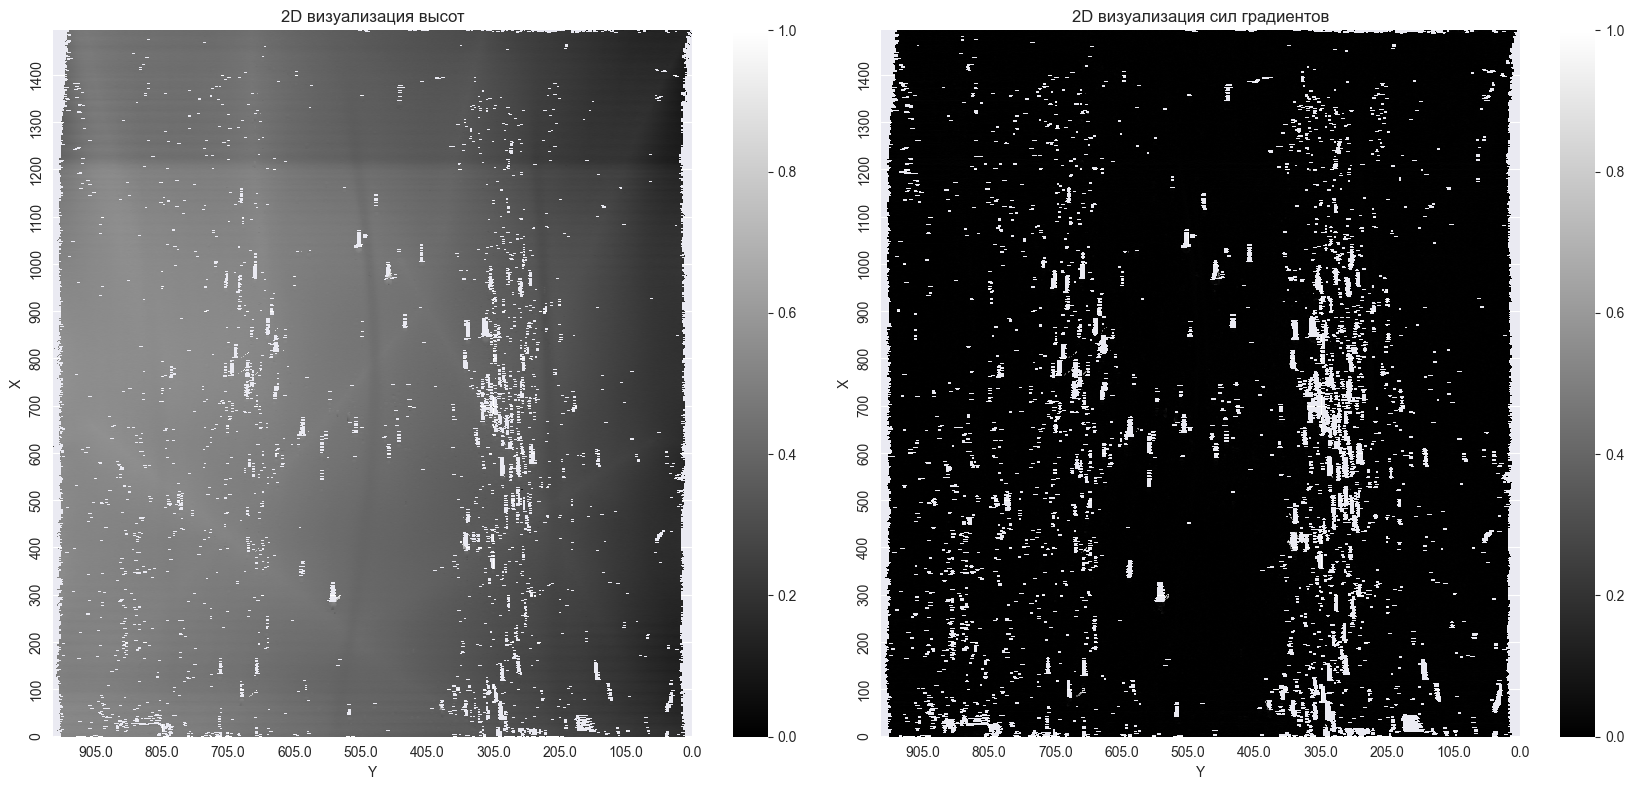

In [116]:
_, ax = plt.subplots(1, 2, figsize=(17, 8))

ax[0].set_xlabel('Y')
ax[0].set_ylabel('X')
ax[0].set_title('2D визуализация высот')

z = points_full['Z']
sns.heatmap(z_pivot, cmap='grey',
            vmin=np.nanmin(z), vmax=np.nanmax(z), ax=ax[0], cbar=True,
            xticklabels=100, yticklabels=100)

ax[0].invert_yaxis()
ax[0].invert_xaxis()

ax[1].set_xlabel('Y')
ax[1].set_ylabel('X')
ax[1].set_title('2D визуализация сил градиентов')

grad_magnitude = points_full['grd_mag']
sns.heatmap(grad_magnitude_pivot, cmap='grey',
            vmin=np.nanmin(grad_magnitude), vmax=np.nanmax(grad_magnitude), ax=ax[1], cbar=True,
            xticklabels=100, yticklabels=100)

ax[1].invert_yaxis()
ax[1].invert_xaxis()

plt.tight_layout()
plt.show()

#### Без пропусков

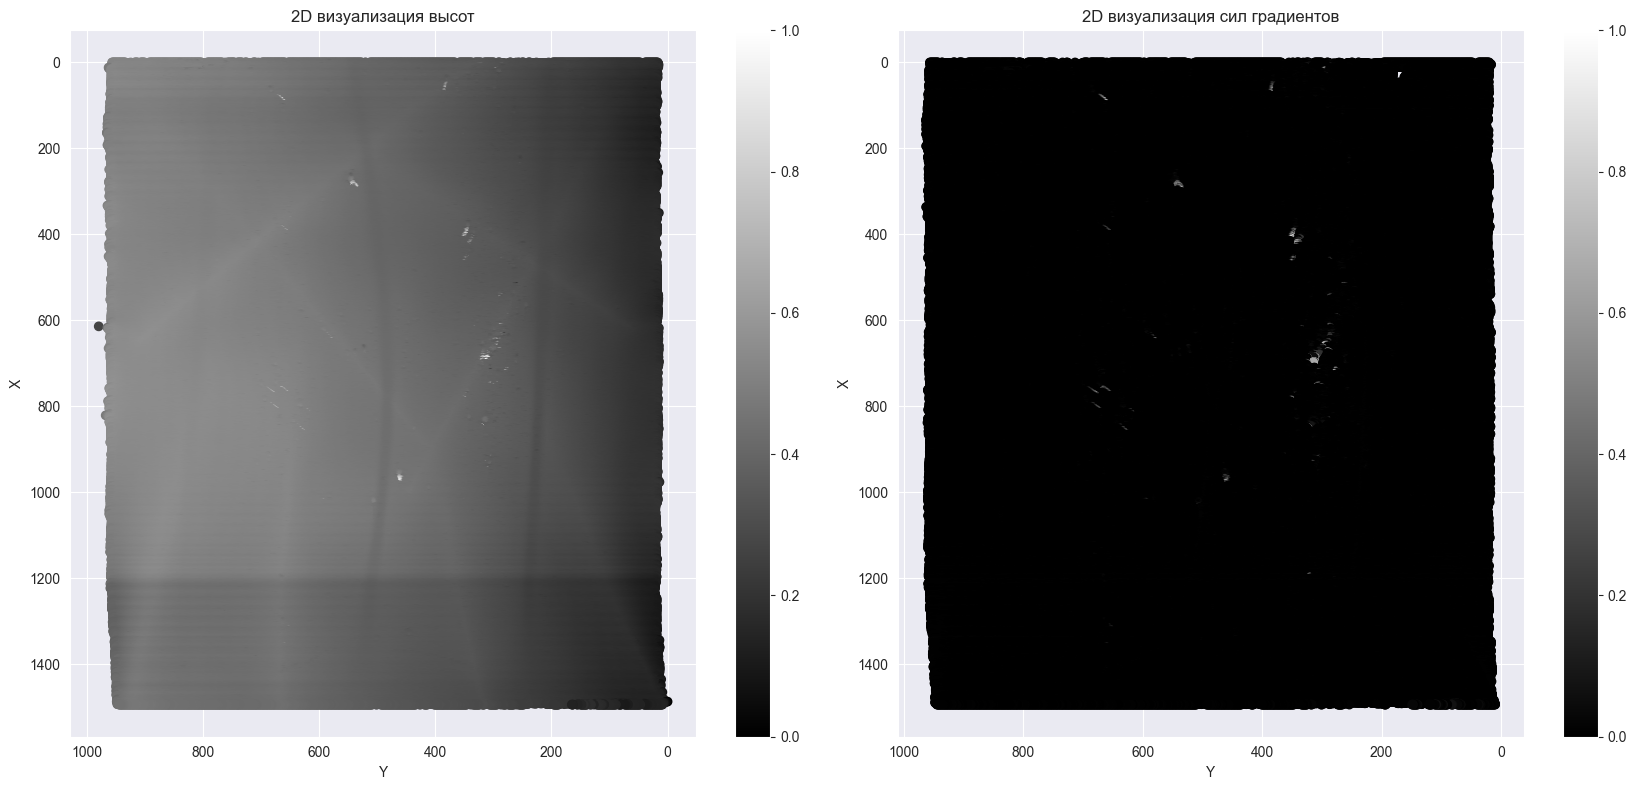

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(17, 8))

ax[0].set_xlabel('Y')
ax[0].set_ylabel('X')
ax[0].set_title('2D визуализация высот')

plot_points = points_full.dropna(subset=['Z'])
x = plot_points['X']
y = plot_points['Y']
z = plot_points['Z']

scatter1 = ax[0].scatter(y, x, c=z, cmap='grey',
                         vmin=min(z), vmax=max(z))
fig.colorbar(scatter1, ax=ax[0])
ax[0].invert_yaxis()
ax[0].invert_xaxis()

ax[1].set_xlabel('Y')
ax[1].set_ylabel('X')
ax[1].set_title('2D визуализация сил градиентов')

plot_points = points_full.dropna(subset=['grd_mag'])
x = plot_points['X']
y = plot_points['Y']
grd_magnitude = plot_points['grd_mag']

scatter2 = ax[1].scatter(y, x, c=grd_magnitude, cmap='grey',
                         vmin=min(grd_magnitude), vmax=max(grd_magnitude))
fig.colorbar(scatter2, ax=ax[1])
ax[1].invert_yaxis()
ax[1].invert_xaxis()

plt.tight_layout()
plt.show()

#### С интерполяцией

##### Высоты

In [118]:
X = points_full['X'].values
Y = points_full['Y'].values
Z = points_full['Z'].values

mask = ~np.isnan(Z)
X_known, Y_known, Z_known = X[mask], Y[mask], Z[mask]

interp = NearestNDInterpolator(list(zip(X_known, Y_known)), Z_known)
Z_filled = interp(X, Y)

grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
z_map = griddata((X, Y), Z_filled, (grid_x, grid_y), method='cubic')
z_map

array([[0.16795794, 0.16795991, 0.16796041, ..., 0.48608394, 0.48188506,
        0.47749475],
       [0.16795794, 0.16795796, 0.1679614 , ..., 0.48841997, 0.48340909,
        0.47821946],
       [0.16795794, 0.16797208, 0.16796857, ..., 0.47325648, 0.47248207,
        0.47237746],
       ...,
       [0.00739063, 0.03613646, 0.06075645, ..., 0.42761193, 0.42751117,
        0.42740074],
       [0.00739063, 0.03166017, 0.05372297, ..., 0.42727182, 0.42729626,
        0.4273029 ],
       [0.04368814, 0.04940137, 0.06068087, ..., 0.42294625, 0.4245806 ,
        0.42607795]], shape=(1494, 980))

In [119]:
# valid_points = points_full.dropna(subset=['Z'])
# 
# X = valid_points['X'].values
# Y = valid_points['Y'].values
# Z = valid_points['Z'].values
# grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
# 
# z_map = griddata((X, Y), Z, (grid_x, grid_y), method='cubic')

In [120]:
z_log = gaussian_laplace(z_map, sigma=10)
z_log = np.nan_to_num(z_log)

# z_map = MinMaxScaler().fit_transform(z_map)
# z_log = MinMaxScaler().fit_transform(z_log)

z_map = pd.DataFrame(z_map, columns=range(int(min(Y)), int(max(Y))))
z_log = pd.DataFrame(z_log, columns=range(int(min(Y)), int(max(Y))))

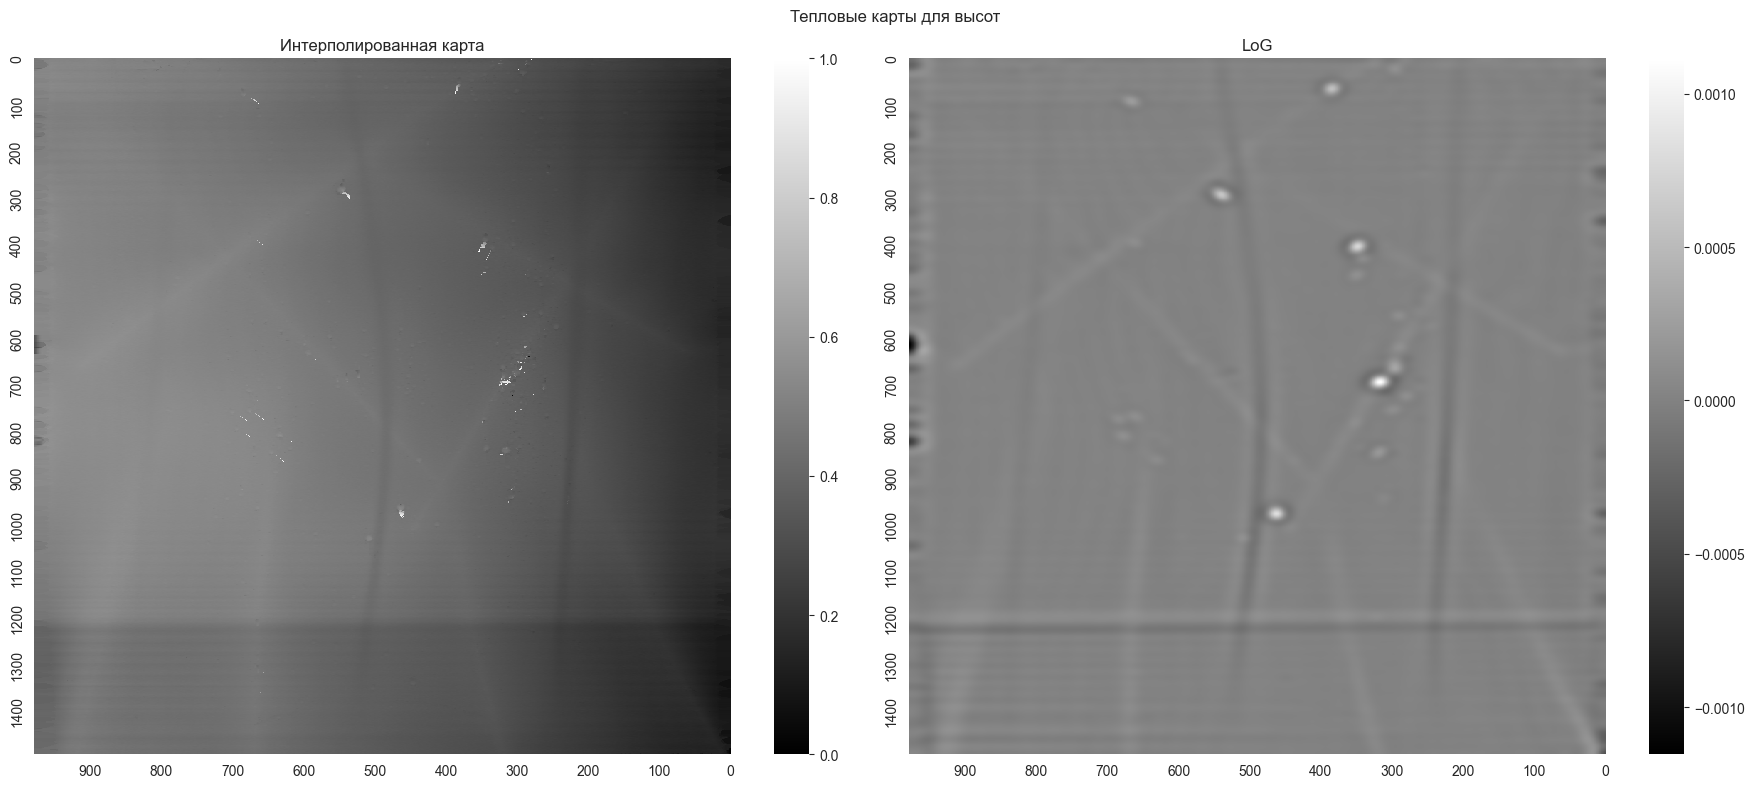

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle("Тепловые карты для высот")

sns.heatmap(z_map, cmap='grey', annot=False, xticklabels=100, yticklabels=100, cbar=True, ax=ax[0])
ax[0].set_title('Интерполированная карта')
ax[0].invert_xaxis()

sns.heatmap(-z_log, cmap='grey', annot=False, xticklabels=100, yticklabels=100, cbar=True, ax=ax[1])
ax[1].set_title('LoG')
ax[1].invert_xaxis()

plt.tight_layout()
plt.show()

##### Градиенты

In [122]:
X = points_full['X'].values
Y = points_full['Y'].values
grd_mag = points_full['grd_mag'].values

mask = ~np.isnan(grd_mag)
X_known, Y_known, grd_mag_known = X[mask], Y[mask], grd_mag[mask]

interp = NearestNDInterpolator(list(zip(X_known, Y_known)), grd_mag_known)
grd_mag_filled = interp(X, Y)

grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
grd_mag_map = griddata((X, Y), grd_mag_filled, (grid_x, grid_y), method='cubic')
grd_mag_map

array([[0.00714719, 0.00714716, 0.00714715, ..., 0.01453467, 0.01453801,
        0.01454305],
       [0.00714719, 0.00714698, 0.00714741, ..., 0.01452377, 0.01453186,
        0.01454073],
       [0.00714719, 0.0071497 , 0.00714902, ..., 0.01454179, 0.01453421,
        0.01453597],
       ...,
       [0.00136236, 0.00150047, 0.001535  , ..., 0.01181098, 0.01187426,
        0.01194361],
       [0.00136236, 0.00191989, 0.00142943, ..., 0.01194628, 0.01195748,
        0.01198003],
       [0.0161192 , 0.01546358, 0.01567886, ..., 0.01202654, 0.01202386,
        0.01202036]], shape=(1494, 980))

In [123]:
# valid_points = points_full.dropna(subset=['grd_mag'])
# 
# X = valid_points['X'].values
# Y = valid_points['Y'].values
# grd_magnitude = valid_points['grd_mag'].values
# 
# grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
# 
# grd_mag_map = griddata((X, Y), grd_magnitude, (grid_x, grid_y), method='cubic')

In [124]:
grd_mag_log = gaussian_laplace(grd_mag_map, sigma=10)
grd_mag_log = np.nan_to_num(grd_mag_log)

# grd_mag_map = MinMaxScaler().fit_transform(grd_mag_map)
# grd_mag_log = MinMaxScaler().fit_transform(grd_mag_log)

grd_mag_map = pd.DataFrame(grd_mag_map, columns=range(int(min(Y)), int(max(Y))))
grd_mag_log = pd.DataFrame(grd_mag_log, columns=range(int(min(Y)), int(max(Y))))

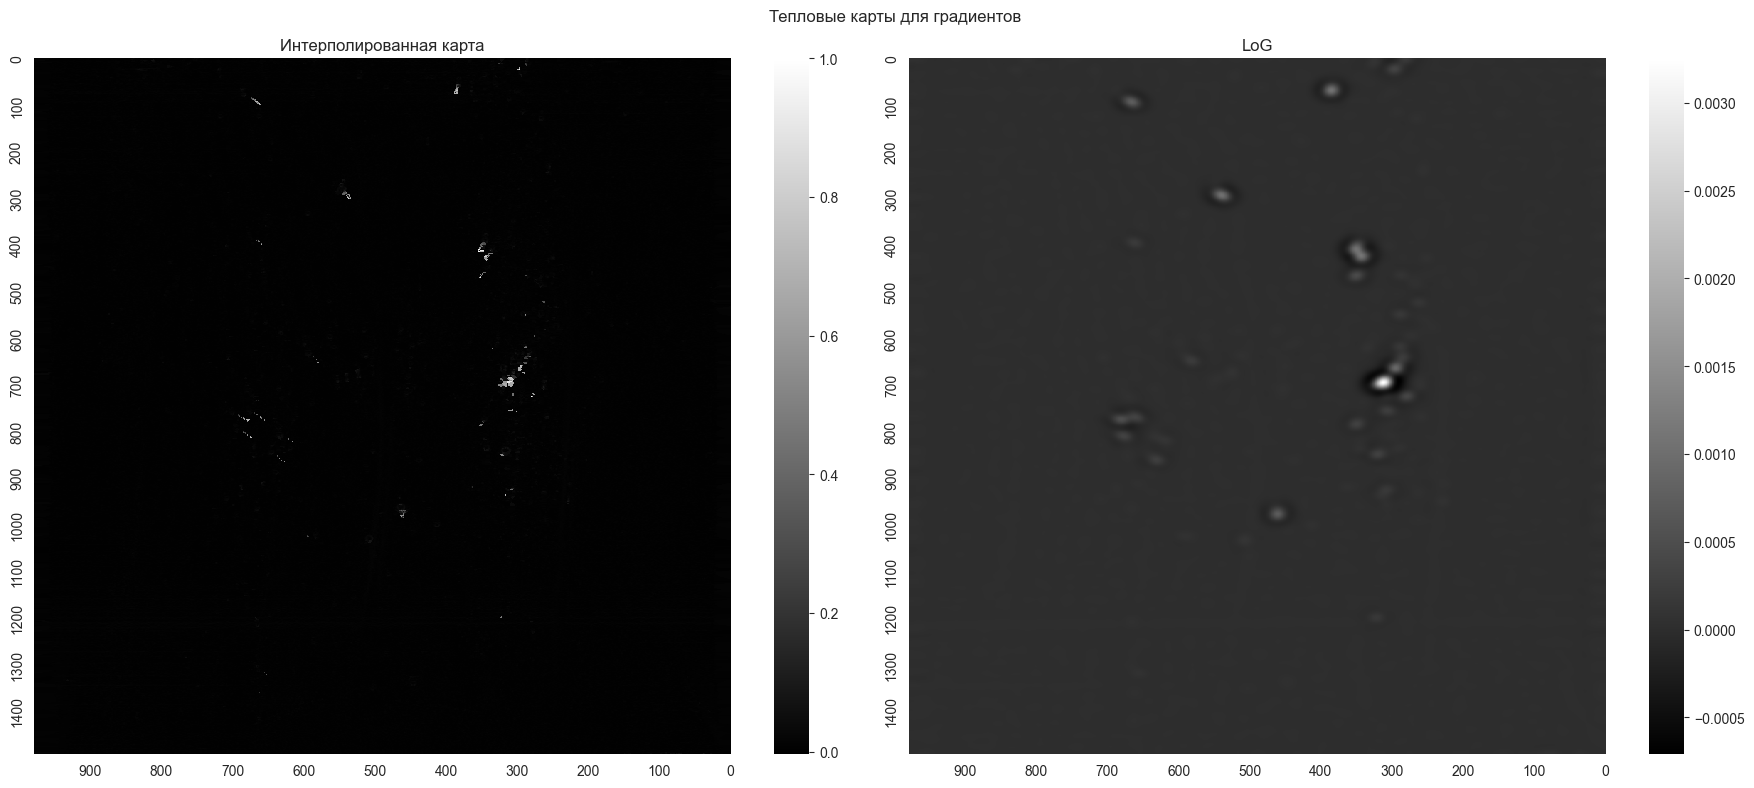

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle("Тепловые карты для градиентов")

sns.heatmap(grd_mag_map, cmap='grey', annot=False, xticklabels=100, yticklabels=100, cbar=True, ax=ax[0])
ax[0].set_title('Интерполированная карта')
ax[0].invert_xaxis()

sns.heatmap(-grd_mag_log, cmap='grey', annot=False, xticklabels=100, yticklabels=100, cbar=True, ax=ax[1])
ax[1].set_title('LoG')
ax[1].invert_xaxis()

plt.tight_layout()
plt.show()

# Контуры

!!! НАДО ПОДОБРАТЬ ПРАВИЛЬНЫЕ ПАРАМЕТРЫ

Функция для поиска/отрисовки контуров и соответствующих им bbox

In [126]:
def draw_contour_and_bbox(image, show=True):
    # blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # clahe = cv2.createCLAHE(clipLimit=5)
    # image = clahe.apply(image)

    adaptive_thresh = cv2.adaptiveThreshold(
        image, 0,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        3, 10
    )

    # kernel = np.ones((3, 3), np.uint8)
    # morph = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    # 
    # contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    bboxes = []
    for contour in contours:
        # if cv2.contourArea(contour) > 1000:
        #     continue

        x, y, w, h = cv2.boundingRect(contour)

        cv2.drawContours(adaptive_thresh, [contour], -1, (0, 0, 255), 1)
        cv2.rectangle(adaptive_thresh, (x, y), (x + w, y + h), (0, 255, 0), 1)

        bboxes.append([x, y, x + w, y + h])

    if show:
        # cv2.namedWindow('Contours with BBoxes', cv2.WINDOW_NORMAL)
        cv2.imshow('Contours with BBoxes', image)
        # cv2.resizeWindow('Contours with BBoxes', img_bgr.shape[1], img_bgr.shape[0])
        # cv2.namedWindow('Contours with BBoxes', cv2.WINDOW_NORMAL)

        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return bboxes

Функция для рассчета максимальной высоты дендрита в заданных областях

In [149]:
def get_max_height_from_bboxes(data, bboxes):
    max_height = float('-inf')

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox

        filtered_points = data[
            (data["X"] >= x1) & (data["X"] <= x2) &
            (data["Y"] >= y1) & (data["Y"] <= y2)
            ].dropna(subset=["Z"])

        if len(filtered_points) > 1:
            max_height = max(max_height, filtered_points["Z"].max() - filtered_points["Z"].min())

    return round(max_height.item(), 2) if max_height != float('-inf') else None

## Высоты

### Интерполяция

In [128]:
# img = z_map.to_numpy()
# img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
# img_uint8 = img_norm.astype(np.uint8)
# bboxes = draw_contour_and_bbox(img_uint8)
# non_processed_res = get_max_height_from_bboxes(points, bboxes)
# z_scaler.inverse_transform(np.array(non_processed_res).reshape(-1, 1)) + z_scaler.data_min_

### LOG

In [129]:
# img = np.nan_to_num(-z_log.to_numpy(), nan=0)
# img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
# img_uint8 = img_norm.astype(np.uint8)
# bboxes = draw_contour_and_bbox(img_uint8)
# non_processed_res = get_max_height_from_bboxes(points, bboxes)
# z_scaler.inverse_transform(np.array(non_processed_res).reshape(-1, 1)) + z_scaler.data_min_

## Градиенты

### Интерполяция

In [150]:
img = grd_mag_map.to_numpy()
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
img_uint8 = img_norm.astype(np.uint8)

bboxes = draw_contour_and_bbox(img_uint8)
non_processed_res = get_max_height_from_bboxes(points, bboxes)
z_scaler.inverse_transform(np.array(non_processed_res).reshape(-1, 1)) + z_scaler.data_min_

array([[nan]])

### LOG

In [151]:
img = np.nan_to_num(-grd_mag_log.to_numpy(), nan=0)
img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
img_uint8 = img_norm.astype(np.uint8)

bboxes = draw_contour_and_bbox(img_uint8)
non_processed_res = get_max_height_from_bboxes(points, bboxes)
z_scaler.inverse_transform(np.array(non_processed_res).reshape(-1, 1)) + z_scaler.data_min_

array([[nan]])

# CV

## Подготовка данных

Функция для LOG карты градиентов

In [131]:
def get_image_log(file_path):
    points = []

    with open(file_path, 'r') as file:
        for x, line in enumerate(file):
            numbers = line.strip().split()

            for i in range(0, len(numbers), 2):
                if i + 1 < len(numbers):
                    y = float(numbers[i])
                    z = float(numbers[i + 1])

                    if 1 < z < 280:
                        points.append([x, y, z])

    points = pd.DataFrame(points, columns=['X', 'Y', 'Z'])
    points['Y'] -= points['Y'].min()

    all_y = sorted(points['Y'].unique())
    all_x = sorted(points['X'].unique())

    full_index = pd.MultiIndex.from_product([all_x, all_y], names=['X', 'Y'])
    points_full = points.set_index(['X', 'Y']).reindex(full_index).reset_index()
    points_full['Z'] = points_full['Z'].where(pd.notnull(points_full['Z']), None)

    z_for_grad = points_full['Z'].to_numpy().reshape(points_full['X'].nunique(), points_full['Y'].nunique())
    dy, dx = np.gradient(z_for_grad)

    gradient_magnitude = np.sqrt(dx ** 2 + dy ** 2)
    grd_mag_scaler = MinMaxScaler()
    points_full['grd_mag'] = grd_mag_scaler.fit_transform(gradient_magnitude.reshape(-1, 1))

    X = points_full['X'].values
    Y = points_full['Y'].values
    grd_mag = points_full['grd_mag'].values

    mask = ~np.isnan(grd_mag)
    X_known, Y_known, grd_mag_known = X[mask], Y[mask], grd_mag[mask]

    interp = NearestNDInterpolator(list(zip(X_known, Y_known)), grd_mag_known)
    grd_mag_filled = interp(X, Y)

    grid_x, grid_y = np.mgrid[min(X):max(X), min(Y):max(Y)]
    grd_mag_map = griddata((X, Y), grd_mag_filled, (grid_x, grid_y), method='cubic')

    grd_mag_log = gaussian_laplace(grd_mag_map, sigma=10)

    return points_full, grd_mag_log

In [ ]:
files_dir = 'Data'
files = [os.path.join(files_dir, f) for f in os.listdir(files_dir)]

output_dir = 'CV_3D/photos'
os.makedirs(output_dir, exist_ok=True)

for i, file in tqdm(enumerate(files), total=len(files)):
    _, current_img = get_image_log(file)
    current_img = cv2.normalize(current_img, None, 0, 255, cv2.NORM_MINMAX)
    current_img = current_img.astype(np.uint8)
    current_img = cv2.cvtColor(current_img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(output_dir + f'/image_{i}.png', current_img)

  0%|          | 0/727 [00:00<?, ?it/s]

## Модель

In [16]:
class BaseCNN(nn.Module):
    def __init__(self, input_size=24):
        super(BaseCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flattened_size = (input_size // 4) * (input_size // 4) * 16

        self.fc = nn.Linear(self.flattened_size, 2)

    def forward(self, x, return_features=False):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        features = x.view(x.size(0), -1)
        out = self.fc(features)

        if return_features:
            return out, features
        return out

In [17]:
model = BaseCNN(input_size=36)
dummy_input = torch.randn(8, 1, 36, 36)

logits, features = model(dummy_input, return_features=True)

print("Logits shape:", logits.shape)
print("Features shape:", features.shape)

Logits shape: torch.Size([8, 2])
Features shape: torch.Size([8, 1296])


## Аннотирование

Функция для действий при нажатии на клавиши мыши

In [34]:
def click_event(event, x, y, flags, params):
    global data

    # Ручной способ задания прямоугольника для дальнейшего сжатия

    # if event == cv2.EVENT_LBUTTONDOWN:
    #     new_row = pd.Series({'x1': x, 'y1': y, 'x2': None, 'y2': None, 'label': None})
    #     data = pd.concat([data, new_row.to_frame().T], ignore_index=True)
    #     print(f'ЛКМ: добавил точку ({x},{y}) как x1, y1')
    # 
    # elif event == cv2.EVENT_RBUTTONDOWN:
    #     idx = data[data['x2'].isnull()].last_valid_index()
    #     if idx is not None:
    #         data.at[idx, 'x2'] = x
    #         data.at[idx, 'y2'] = y
    #         print(f'ПКМ: добавил точку ({x},{y}) как x2, y2')

    if event == cv2.EVENT_LBUTTONDOWN:
        x1, y1 = x - 18, y - 18
        x2, y2 = x + 18, y + 18

        new_row = pd.Series({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'label': None})
        data = pd.concat([data, new_row.to_frame().T], ignore_index=True)
        print(f'ЛКМ: добавил прямоугольник ({x},{y}) как x1, y1')

Функция для действий при нажатии на кнопку

In [35]:
def key_event():
    global data
    while True:
        key = cv2.waitKey(0) & 0xFF
        idx = data[data['label'].isnull()].last_valid_index()

        if key == ord('w') and idx is not None:
            data.at[idx, 'label'] = 1
            print('label = 1')
        elif key == ord('s') and idx is not None:
            data.at[idx, 'label'] = 0
            print('label = 0')
        elif key == ord('t'):
            save_patches()
            return 'continue'
        elif key == ord('q'):
            save_all_tensors()
            return 'end'

Функция для сохранения патчей

In [36]:
def save_patches():
    global current_img, data, all_tensors, all_labels, all_images

    for i, row in data.iterrows():
        if pd.isnull(row[['x1', 'y1', 'x2', 'y2', 'label']]).any():
            continue

        x1, y1, x2, y2 = map(int, [row['x1'], row['y1'], row['x2'], row['y2']])
        xmin, xmax = min(x1, x2), max(x1, x2)
        ymin, ymax = min(y1, y2), max(y1, y2)

        patch = current_img[ymin:ymax, xmin:xmax]
        patch = cv2.resize(patch, (36, 36))
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)

        # TODO надо потестить
        # patch = cv2.adaptiveThreshold(
        #     patch, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        #     cv2.THRESH_BINARY, 11, 2
        # )

        patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0)

        # patch_tensor /= 255.0

        all_tensors.append(patch_tensor)
        all_labels.append(int(row["label"]))
        all_images.append(patch)

    data = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'label'])

Функция для сохранения финальных тензоров

In [69]:
# filtered_tensors = []
# filtered_labels = []
# 
# for tensor, label in zip(all_tensors, all_labels):
#     if tensor.shape == (1, 36, 36, 3):
#         patch = tensor.squeeze(0).numpy()
#         patch= cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
#         patch_tensor = torch.tensor(patch, dtype=torch.float32).unsqueeze(0)
#         filtered_tensors.append(patch_tensor)
#         filtered_labels.append(label)
#     else:
#         print(f"Skipping tensor with shape {tensor.shape}")
# 
# if filtered_tensors: 
#     try:
#         all_tensors_tensor = torch.stack(filtered_tensors)
#         torch.save(all_tensors_tensor, 'CV_3D/Train/images.pt')
#         torch.save(filtered_labels, 'CV_3D/Train/labels.pt')
#         print(f"Successfully saved {len(filtered_tensors)} tensors with shape [1, 36, 36, 3]")
#     except Exception as e:
#         print(f"Error while stacking and saving tensors: {e}")
# else:
#     print("No tensors with the correct shape [1, 36, 36, 3] were found")

Skipping tensor with shape torch.Size([1, 36, 33, 3])
Skipping tensor with shape torch.Size([1, 36, 24, 3])
Skipping tensor with shape torch.Size([1, 36, 31, 3])
Skipping tensor with shape torch.Size([1, 36, 33, 3])
Skipping tensor with shape torch.Size([1, 36, 0, 3])
Skipping tensor with shape torch.Size([1, 36, 0, 3])
Skipping tensor with shape torch.Size([1, 0, 36, 3])
Skipping tensor with shape torch.Size([1, 36, 34, 3])
Skipping tensor with shape torch.Size([1, 0, 36, 3])
Skipping tensor with shape torch.Size([1, 36, 0, 3])
Skipping tensor with shape torch.Size([1, 35, 36, 3])
Skipping tensor with shape torch.Size([1, 0, 36, 3])
Skipping tensor with shape torch.Size([1, 0, 36, 3])
Skipping tensor with shape torch.Size([1, 0, 36, 3])
Skipping tensor with shape torch.Size([1, 0, 36, 3])
Skipping tensor with shape torch.Size([1, 36, 33, 3])
Skipping tensor with shape torch.Size([1, 0, 36, 3])
Skipping tensor with shape torch.Size([1, 0, 36, 3])
Skipping tensor with shape torch.Size([

In [37]:
def save_all_tensors():
    global all_tensors, all_labels
    try:
        all_tensors_tensor = torch.stack(all_tensors)
        torch.save(all_tensors_tensor, 'CV_3D/Train/images.pt')
        torch.save(all_labels, 'CV_3D/Train/labels.pt')
        print(f'Сохранены все тензоры и лейблы {len(all_labels)}')

        for i, image in enumerate(all_images):
            cv2.imwrite(f'CV_3D/Train/Images/image_{i}.png', image)

    except Exception as e:
        print(e)
        print('Данные не были сохранены')

In [24]:
data = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'label'])

photo_dir = 'CV_3D/photos'
photos = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]

output_dir = 'CV_3D/Train'
os.makedirs(output_dir, exist_ok=True)

current_img = None

all_tensors = []
all_labels = []
all_images = []

for photo in photos:
    current_img = cv2.imread(photo)
    cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
    cv2.imshow('frame', current_img)

    cv2.setMouseCallback('frame', click_event)
    res = key_event()

    cv2.destroyAllWindows()

    if res == 'end':
        break

ЛКМ: добавил прямоугольник (379,202) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (561,203) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (637,209) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (630,426) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (657,408) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (543,663) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (725,919) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (676,1016) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (644,1048) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (498,1431) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (569,1422) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (765,1425) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (788,1401) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (660,1456) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (435,1439) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (396,1431) как x1, y1
label = 1
ЛКМ: добавил прямоугольник (354,1419) как x1, y1
label = 1
ЛКМ:

## Обучение

Функция обучения

In [51]:
def train(
        model: nn.Module,
        data_loader: DataLoader,
        optimizer: Optimizer,
        loss_fn,
        device: torch.device,
) -> tuple[float, float]:
    model.train()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Train"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

Функция для валидации

In [52]:
@torch.inference_mode()
def evaluate(
        model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device
) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc="Evaluate"):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

Функция для вывода статистики

In [53]:
def plot_stats(
        train_loss: list[float],
        valid_loss: list[float],
        train_accuracy: list[float],
        valid_accuracy: list[float],
        title: str,
):
    plt.figure(figsize=(16, 8))

    plt.title(title + " loss")

    plt.plot(train_loss, label="Train loss")
    plt.plot(valid_loss, label="Valid loss")
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + " accuracy")

    plt.plot(train_accuracy, label="Train accuracy")
    plt.plot(valid_accuracy, label="Valid accuracy")
    plt.legend()
    plt.grid()

    plt.show()

Функция для цикла обучения и валидации

In [54]:
def whole_train_valid_cycle(
        model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold, title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        scheduler.step()

        if valid_accuracy >= threshold:
            break

Запуск обучения

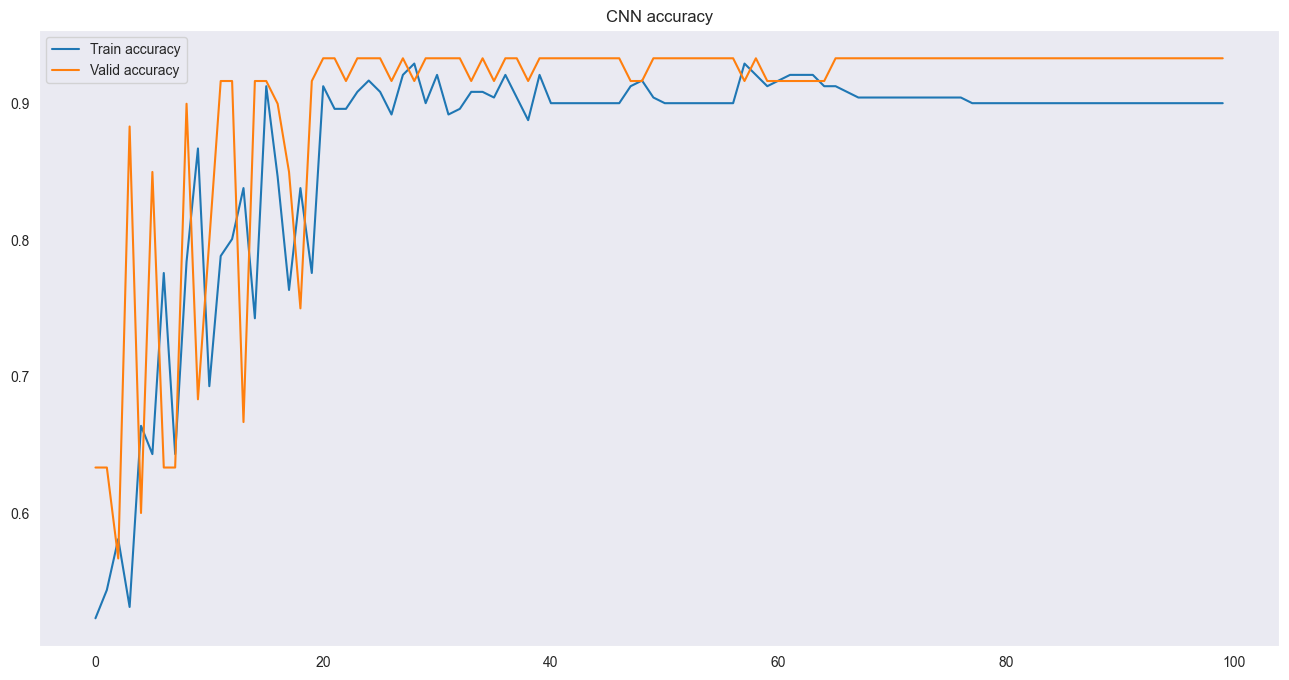

In [70]:
images = torch.load('CV_3D/Train/images.pt')
labels = torch.load('CV_3D/Train/labels.pt')

if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

full_dataset = TensorDataset(images, labels)

val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

model = BaseCNN(input_size=36).to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

whole_train_valid_cycle(
    model, train_loader, valid_loader, optimizer, loss_fn, scheduler, device, threshold=1, title='CNN'
)

torch.save(model.state_dict(), "CV_3D/model.pt")

## Инференс тест

In [86]:
images = torch.load('CV_3D/Train/images.pt')
labels = torch.load('CV_3D/Train/labels.pt')

if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

full_dataset = TensorDataset(images, labels)

val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

_, val_dataset = random_split(full_dataset, [train_size, val_size])

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

model = BaseCNN(input_size=36).to(device)
model.load_state_dict(torch.load('CV_3D/model.pt'))
model.eval()

all_logits = []
all_preds = []
all_labels = []
all_features = []

with torch.no_grad():
    for batch_imgs, batch_labels in val_loader:
        batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
        logits, features = model(batch_imgs, return_features=True)
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)

        all_logits.append(logits.cpu())
        all_preds.append(preds.cpu())
        all_labels.append(batch_labels.cpu())
        all_features.append(features.cpu())

all_logits = torch.cat(all_logits)
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_features = torch.cat(all_features)

print(f'Accuracy - {round((all_preds == all_labels).float().mean().item(), 2)}')

Accuracy - 0.92


Посмотрим на фичи

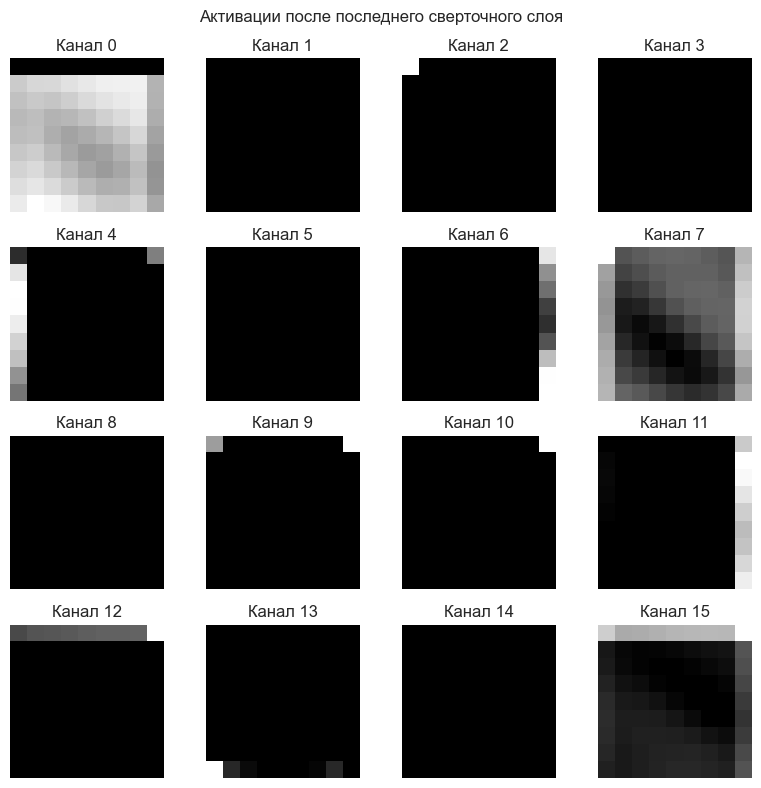

In [93]:
images = torch.load('CV_3D/Train/images.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

img = images[0].unsqueeze(0).to(device)

model = BaseCNN(input_size=36).to(device)
model.load_state_dict(torch.load('CV_3D/model.pt'))
model.eval()

with torch.no_grad():
    x = model.relu(model.conv1(img))
    x = model.pool(x)
    x = model.relu(model.conv2(x))
    features = model.pool(x)

features = features.squeeze(0).cpu()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(features[i], cmap='gray')
    ax.set_title(f'Канал {i}')
    ax.axis('off')

plt.suptitle('Активации после последнего сверточного слоя')
plt.tight_layout()
plt.show()

## Инференс прод

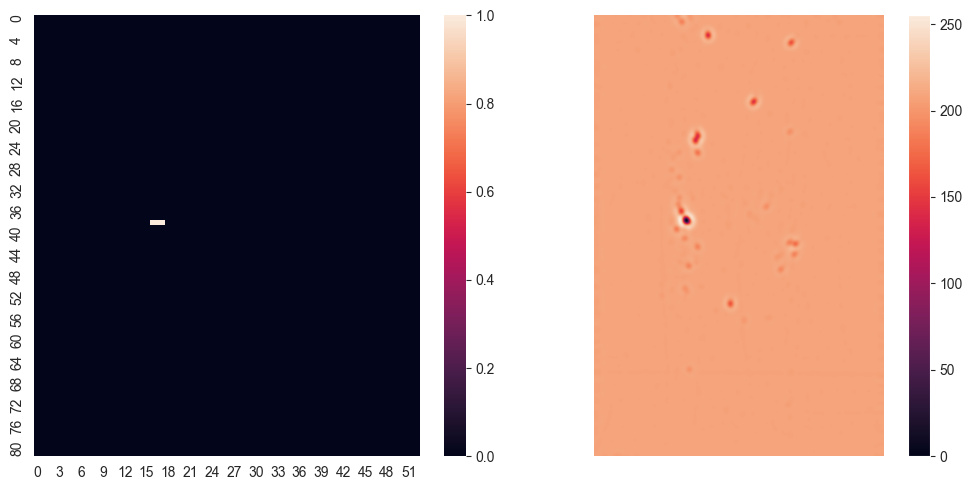

In [136]:
image_path = None
# image_path = 'img.png'
file_path = "192.168.25.105_1710930733.txt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BaseCNN(input_size=36).to(device)
model.load_state_dict(torch.load('CV_3D/model.pt'))
model.eval()

data, image = get_image_log(file_path=file_path)
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
image = image.astype(np.uint8)
image_np = np.array(image)

transform = transforms.Compose([
    transforms.ToTensor(),
])

stride = 18
window_size = 36
arr = np.zeros((math.floor((image_np.shape[0] - window_size) / stride) + 1,
                math.floor((image_np.shape[1] - window_size) / stride) + 1))

positive_images = []
positive_images_bbox = []

for i, y in enumerate(range(0, image_np.shape[0] - window_size + 1, stride)):
    for j, x in enumerate(range(0, image_np.shape[1] - window_size + 1, stride)):
        patch = image_np[y:y + window_size, x:x + window_size]
        patch_tensor = transform(patch).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(patch_tensor)
            pred = torch.argmax(output, dim=1).item()

        if pred:
            positive_images.append(patch)
            positive_images_bbox.append([x, y, x + window_size, y + window_size])

        arr[i, j] = pred

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(arr, ax=ax[0])

imshow = ax[1].imshow(plt.imread(image_path)) if image_path else ax[1].imshow(image_np)
fig.colorbar(imshow, ax=ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()

In [137]:
len(positive_images)

2

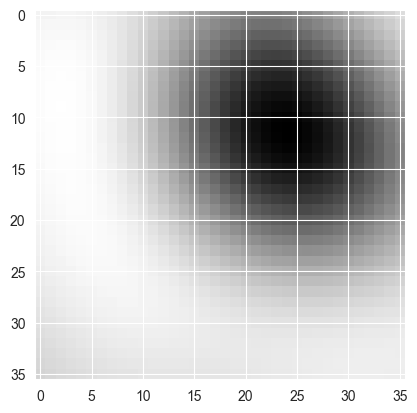

In [138]:
plt.imshow(positive_images[0], cmap='gray')

# Пробуем определять высоту

In [148]:
def get_max_height_from_bboxes(data, bboxes):
    max_height = float('-inf')

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox

        filtered_points = data[
            (data["X"] >= x1) & (data["X"] <= x2) &
            (data["Y"] >= y1) & (data["Y"] <= y2)
            ].dropna(subset=["Z"])

        if len(filtered_points) > 1:
            max_height = max(max_height, filtered_points["Z"].max() - filtered_points["Z"].min())

    return round(max_height.item(), 2) if max_height != float('-inf') else None


get_max_height_from_bboxes(data, positive_images_bbox)

3.67